In [26]:
from pathlib import Path
import os, sys
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Make sure we're running from the repo root, not notebooks/
repo_root = Path.cwd().parent.parent
# os.chdir(repo_root)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from common.config_manager import ConfigManager
from common.io import read_csv

# Breakout Artists - EDA

## Context
We start from scrobble-level data (1 row per scrobble).  
The goal of this notebook is to:
1) Validate the dataset is clean enough to use
2) Extract initial insights relevant to the breakout problem
3) Decide what aggregations and features are worth building


In [2]:
cfg = ConfigManager(repo_root)
project_cfg = cfg.project()
sources_cfg = cfg.sources()
breakout_cfg = cfg.breakout()

scrobbles_path = repo_root / sources_cfg["scrobbles"]["path"]
required_cols = sources_cfg["scrobbles"]["required_columns"]

df_raw = read_csv(scrobbles_path)
print("Raw shape:", df_raw.shape)
df_raw.head(10)


Raw shape: (160830, 37)


D:\Transferências\Desktop\01. Projects\09. ML Zoomcamp\artist-lifecycle\common\io.py:49: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, usecols=usecols, dtype=dtype, parse_dates=parse_dates)


,scrobble_number,username,track_name,track_mbid,date,artist_name,artist_mbid,album_name,album_mbid,artist_listeners,...,added_at_utc_was_missing,week_saturday_utc_was_missing,spotify_release_date_was_missing,genre_bucket,genre_missing,artist_listeners_was_missing,artist_playcount_was_missing,album_listeners_was_missing,album_playcount_was_missing,spotify_popularity_was_missing
0,1,Tyains,Lover Boy - A COLORS SHOW,NaN,2020-04-01 17:47:00,Phum Viphurit,8dc1023a-8c0a-4b59-8727-dd5bd22e0524,Lover Boy - A COLORS SHOW,NaN,238293,...,1,0,0,pop,0,0,0,0,0,0
1,2,Tyains,Pluto - Audiotree Live Version,NaN,2020-04-01 17:43:00,Phum Viphurit,NaN,Phum Viphurit on Audiotree Live,NaN,238293,...,1,0,0,pop,0,0,0,0,0,0
2,3,Tyains,"Hello, Anxiety - Audiotree Live Version",NaN,2020-04-01 17:39:00,Phum Viphurit,NaN,Phum Viphurit on Audiotree Live,NaN,238293,...,1,0,0,pop,0,0,0,0,0,0
3,4,Tyains,Sanctuary,02c2b134-62a8-4e72-8236-fb9b7faed23b,2020-04-01 17:35:00,Joji,8264722b-df00-467a-858e-5c97cda169c9,Sanctuary,20dd31b3-8174-4aff-8e73-5140d2a06c08,2033690,...,1,0,0,unknown,1,0,0,0,0,0
4,5,Tyains,Excuse Me,53e393f4-5e41-4a4d-86c0-01952c69cbd8,2020-04-01 17:30:00,Salvador Sobral,ad226273-7870-47d6-a8d0-903ddba3853d,Excuse Me,f63f9325-b5d7-4e5c-8184-fd9d0682978f,67237,...,1,0,0,world_regional,0,0,0,0,0,0
5,6,Tyains,Mano a Mano,NaN,2020-04-01 17:26:00,Salvador Sobral,ad226273-7870-47d6-a8d0-903ddba3853d,Mano a Mano,NaN,67237,...,1,0,0,world_regional,0,0,0,0,0,0
6,7,Tyains,Anda Estragar-me Os Planos,1e4a1d11-08fc-4f02-b557-08f87768c725,2020-04-01 17:23:00,Salvador Sobral,ad226273-7870-47d6-a8d0-903ddba3853d,"Paris, Lisboa",a0898280-0763-4dd9-bf60-af91d34071ca,67237,...,1,0,0,world_regional,0,0,0,0,0,0
7,8,Tyains,Só Um Beijo,NaN,2020-04-01 17:20:00,Luisa Sobral,NaN,Rosa,NaN,13960,...,1,0,0,world_regional,0,0,0,0,0,0
8,9,Tyains,Amar pelos dois,4810c5b5-4a04-40d2-bb0b-8769445ecc72,2020-04-01 17:17:00,Salvador Sobral,ad226273-7870-47d6-a8d0-903ddba3853d,Amar pelos dois,0874be69-2918-4ff4-ab19-6a632ed17675,67237,...,1,0,0,world_regional,0,0,0,0,0,0
9,10,Tyains,Antes dela dizer que sim,ec4cccd2-93ae-40a9-8d4f-39a3edafed62,2020-04-01 17:13:00,Bárbara Tinoco,4268daf5-68f2-4c6e-a8c7-3e1d17fbf011,Antes Dela Dizer Que Sim,051b150b-e576-4836-932b-39e966b21208,15531,...,1,0,0,hip_hop_rap,0,0,0,0,0,0


## Profiling - quick overview

In [3]:
print("Columns:", list(df_raw.columns))
print(f"Rows: {len(df_raw):,} | Columns: {len(df_raw.columns)}")

print(pd.DataFrame({"column": df_raw.columns, "dtype": df_raw.dtypes.values}))

print("Unique artists:", df_raw["artist_name"].nunique() if "artist_name" in df_raw.columns else None)
print("Unique tracks:", df_raw["track_name"].nunique() if "track_name" in df_raw.columns else None)

df_raw[required_cols].head(5)

Columns: ['scrobble_number', 'username', 'track_name', 'track_mbid', 'date', 'artist_name', 'artist_mbid', 'album_name', 'album_mbid', 'artist_listeners', 'artist_playcount', 'artist_key', 'track_duration', 'track_key', 'album_listeners', 'album_playcount', 'album_key', 'spotify_track_id', 'spotify_album', 'spotify_release_date', 'spotify_popularity', 'spotify_genres', 'week_saturday_utc', 'added_at_utc', 'is_week_favorite', 'release_date_granularity', 'date_was_missing', 'added_at_utc_was_missing', 'week_saturday_utc_was_missing', 'spotify_release_date_was_missing', 'genre_bucket', 'genre_missing', 'artist_listeners_was_missing', 'artist_playcount_was_missing', 'album_listeners_was_missing', 'album_playcount_was_missing', 'spotify_popularity_was_missing']
Rows: 160,830 | Columns: 37
                              column    dtype
0                    scrobble_number    int64
1                           username   object
2                         track_name   object
3                    

,artist_name,track_name,date
0,Phum Viphurit,Lover Boy - A COLORS SHOW,2020-04-01 17:47:00
1,Phum Viphurit,Pluto - Audiotree Live Version,2020-04-01 17:43:00
2,Phum Viphurit,"Hello, Anxiety - Audiotree Live Version",2020-04-01 17:39:00
3,Joji,Sanctuary,2020-04-01 17:35:00
4,Salvador Sobral,Excuse Me,2020-04-01 17:30:00


In [4]:
# A compact summary
profile_table = df_raw.describe(include='all').T
profile_table

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
scrobble_number,160830.0,NaN,NaN,NaN,80415.5,46427.766234,1.0,40208.25,80415.5,120622.75,160830.0
username,160830,1,Tyains,160830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
track_name,160830,25420,Intro,284,NaN,NaN,NaN,NaN,NaN,NaN,NaN
track_mbid,117971,17902,ddea782b-e8df-4291-823a-d72a5e7b15e1,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,160830,158723,2025-09-08 21:19:00,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artist_name,160830,2920,King Gizzard & The Lizard Wizard,5444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artist_mbid,129158,2045,f58384a4-2ad2-4f24-89c5-c7b74ae1cce7,5233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
album_name,160829,6323,Ants From Up There,781,NaN,NaN,NaN,NaN,NaN,NaN,NaN
album_mbid,121976,3250,0788e1b9-d989-4a8f-9a9a-244d6338f014,781,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artist_listeners,160830.0,NaN,NaN,NaN,1532794.778729,3884957.928297,2.0,305793.0,767778.0,2051759.0,124096307.0


## Missing values

In [5]:
missing = (
    df_raw.isna()
    .sum()
    .rename("missing")
    .to_frame()
)
missing["pct"] = (missing["missing"] / len(df_raw)).round(4)
missing = missing.sort_values(["pct", "missing"], ascending=False)

missing.head(30)


,missing,pct
added_at_utc,158752,0.9871
spotify_genres,46585,0.2897
track_mbid,42859,0.2665
album_mbid,38854,0.2416
artist_mbid,31672,0.1969
spotify_album,8176,0.0508
spotify_track_id,8175,0.0508
spotify_release_date,8175,0.0508
release_date_granularity,8175,0.0508
album_name,1,0.0000


## String cleanliness (artist_name / track_name)

In [6]:
artist_empty = df_raw["artist_name"].astype("string").str.strip().eq("").sum()
track_empty = df_raw["track_name"].astype("string").str.strip().eq("").sum()

print("Empty artist_name after strip:", artist_empty)
print("Empty track_name after strip:", track_empty)

# quick peek at suspicious rows
df_raw.loc[
    df_raw["artist_name"].astype("string").str.strip().eq("") |
    df_raw["track_name"].astype("string").str.strip().eq(""),
    ["artist_name", "track_name", "date"]
].head(10)


Empty artist_name after strip: 0
Empty track_name after strip: 0


,artist_name,track_name,date


## Date column - parse checks, range, invalid values

In [7]:
played = pd.to_datetime(df_raw["date"], utc=True, errors="coerce")

invalid = played.isna().sum()
print("Invalid date values:", invalid)
print("Invalid date %:", round(invalid / len(df_raw), 6))

if invalid > 0:
    bad_examples = df_raw.loc[played.isna(), "date"].head(10).tolist()
    print("Bad examples:", bad_examples)

print("Min played_at_utc:", played.min())
print("Max played_at_utc:", played.max())

# future check (defensive)
now_utc = pd.Timestamp.now().tz_localize("UTC")
future_rows = (played > now_utc).sum()
print("Future timestamps:", future_rows)


Invalid date values: 0
Invalid date %: 0.0
Min played_at_utc: 2020-03-17 01:02:00+00:00
Max played_at_utc: 2025-11-11 17:31:00+00:00
Future timestamps: 0


## Duplicates

In [8]:
dup_exact = int(df_raw.duplicated().sum())

dup_scrobble = None
if "scrobble_number" in df_raw.columns:
    dup_scrobble = int(df_raw.duplicated(subset=["scrobble_number"]).sum())

pd.DataFrame(
    [
        {"check": "exact_row", "dupe_count": dup_exact},
        {"check": "scrobble_number", "dupe_count": dup_scrobble},
    ]
)

,check,dupe_count
0,exact_row,0
1,scrobble_number,0


## Basic time activity overview
We want to understand volume, coverage, and whether the dataset spans enough history for artist-month modeling.

In [9]:
played_ok = played.dropna()
month = played_ok.dt.strftime("%Y-%m-01")
month = pd.to_datetime(month, utc=True)

scrobbles_per_month = (
    pd.Series(1, index=month)
    .groupby(level=0)
    .sum()
    .sort_index()
)

print("Months:", scrobbles_per_month.index.min(), "->", scrobbles_per_month.index.max())
print('Min Monhtly Scrobbles:', scrobbles_per_month.min() )
print('Max Monhtly Scrobbles:', scrobbles_per_month.max() )


Months: 2020-03-01 00:00:00+00:00 -> 2025-11-01 00:00:00+00:00
Min Monhtly Scrobbles: 764
Max Monhtly Scrobbles: 5027


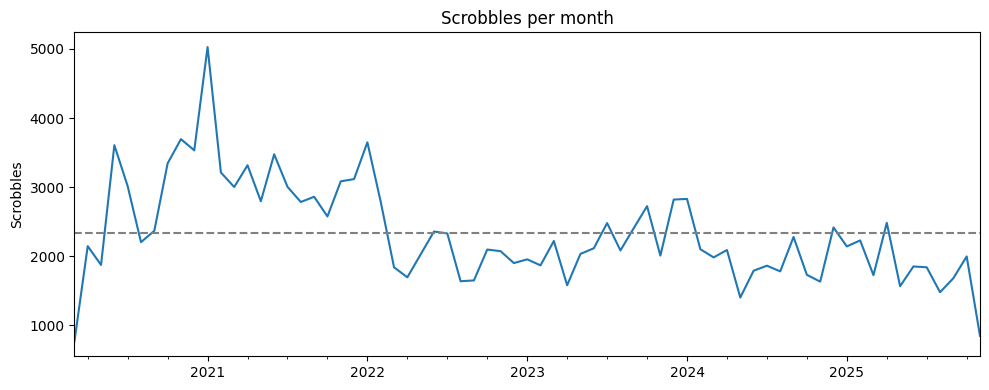

In [10]:
y_mean = scrobbles_per_month.mean()

plt.figure(figsize=(10, 4))
scrobbles_per_month.plot(kind="line")
plt.axhline(y_mean, linestyle="--", color="grey")
plt.title("Scrobbles per month")
plt.xlabel("")
plt.ylabel("Scrobbles")
plt.tight_layout()
plt.show()


              genre_bucket  scrobbles
0                  unknown      46585
1              hip_hop_rap      38217
2                     rock      14494
3                      pop      14108
4                    other      12553
5   folk_country_americana       6826
6                 rnb_soul       6758
7            classical_art       5627
8           world_regional       4145
9                    latin       3497
10        electronic_dance       2577
11                    jazz       2562
12      experimental_avant       1955
13              metal_hard        926


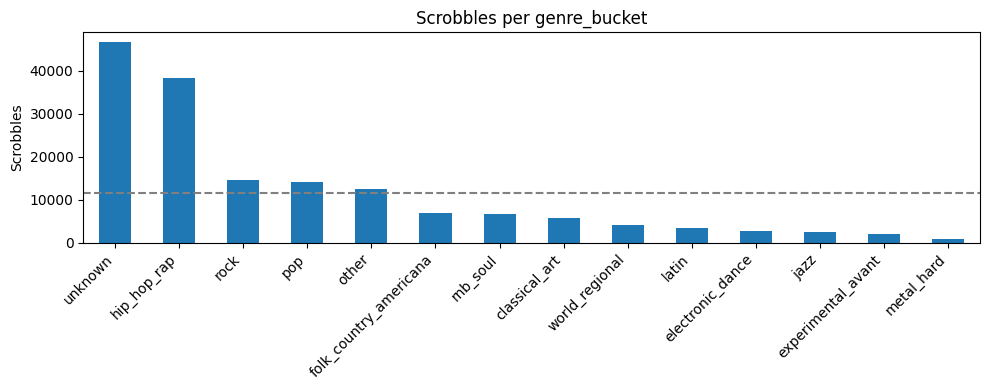

In [11]:

genre_counts = (
    df_raw["genre_bucket"]
    .fillna("Unknown")
    .astype("string")
    .str.strip()
    .replace({"": "Unknown"})
    .value_counts()
)

print(genre_counts.head(20).rename_axis("genre_bucket").reset_index(name="scrobbles"))

y_mean = genre_counts.mean()

plt.figure(figsize=(10, 4))
genre_counts.plot(kind="bar")
plt.axhline(y_mean, linestyle="--", color="grey")
plt.title("Scrobbles per genre_bucket")
plt.xlabel("")
plt.ylabel("Scrobbles")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Visual EDA

**Goal:** Breakout Artist Detection (Binary Classification)
**Unit of Analysis:** Artist-Month (Testing the validity of this unit in EDA below)

**Definitions (Hypothesis to Validate):**
* **Eligibility (The "New" Cohort):**
    * First seen < 6 months ago (Recent discovery)
    * Current month plays $\ge$ 3 (Not just a randomly listening in a playlist)
    * Not already "Core" (Max prior plays < 20)
* **Target Label (The "Breakout"):**
    * Becomes "Core" (Plays $\ge$ 20 OR Share $\ge$ 1%) in month $t+1$ or $t+2$.

## Initial distribution checks (artists / tracks)

                             artist  scrobbles
0  King Gizzard & The Lizard Wizard       5444
1                        Kanye West       4658
2                    Sufjan Stevens       4408
3                         JPEGMAFIA       3650
4                     Freddie Gibbs       2326
5                       Ichiko Aoba       2283
6                    Kendrick Lamar       2035
7                       David Bruno       2026
8                       Beach House       1952
9                       Fleet Foxes       1950

Mean top 100 artists: 917.37


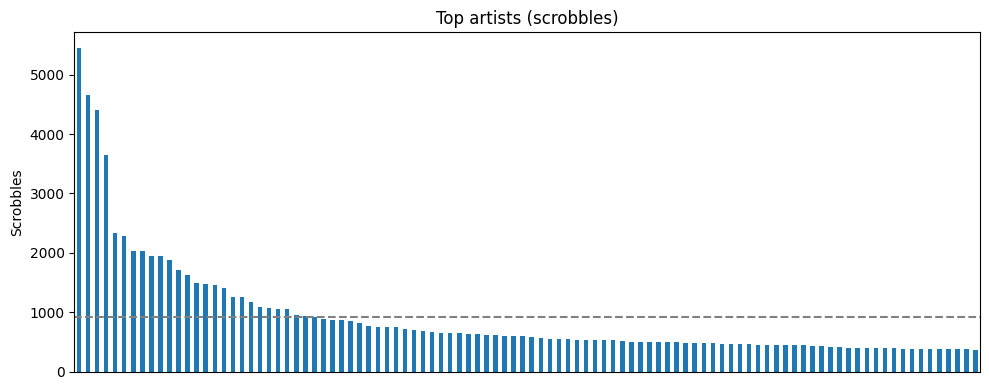

                              track_name              artist_name  scrobbles
0                               Concorde  Black Country, New Road        125
1                           Weird Fishes          Lianne La Havas        117
2                       Basketball Shoes  Black Country, New Road        115
3                     Chaos Space Marine  Black Country, New Road        112
4                          Feel the Love          KIDS SEE GHOSTS        104
5                       HAZARD DUTY PAY!                JPEGMAFIA        103
6                     Helplessness Blues              Fleet Foxes        100
7                             Sunglasses  Black Country, New Road         99
8  The Place Where He Inserted The Blade  Black Country, New Road         99
9                                Runaway               Kanye West         97

Mean top 100 tracks: 76.32


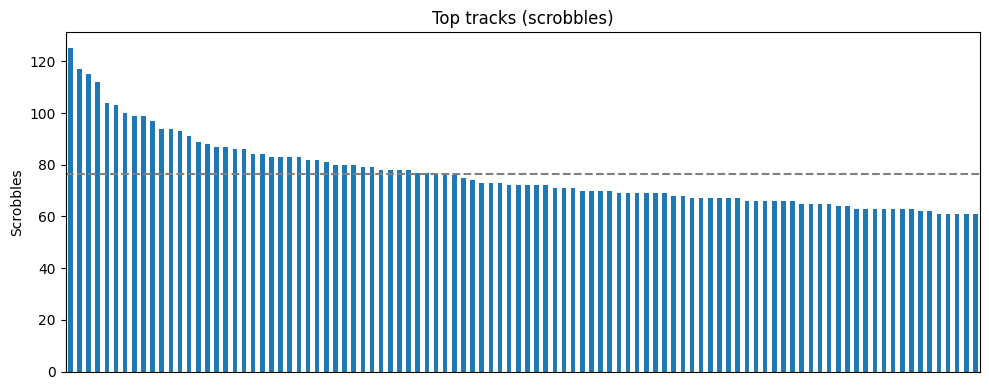

In [12]:
top_n = 100

top_artists = df_raw["artist_name"].astype("string").str.strip().value_counts().head(top_n)
y_mean = top_artists.mean()

print(top_artists.head(10).rename_axis("artist").reset_index(name="scrobbles"))
print(f"\nMean top {top_n} artists: {y_mean}")

plt.figure(figsize=(10, 4))
top_artists.plot(kind="bar")
plt.axhline(y_mean, linestyle="--", color="grey")
plt.title("Top artists (scrobbles)")
plt.xlabel("")
plt.ylabel("Scrobbles")
plt.xticks([], [])
plt.tight_layout()
plt.show()


top_tracks = df_raw[["track_name", "artist_name"]].astype("string").apply(lambda s: s.str.strip()).value_counts().head(top_n)
y_mean = top_tracks.mean()

print(top_tracks.head(10).reset_index(name="scrobbles"))
print(f"\nMean top {top_n} tracks: {y_mean}")

plt.figure(figsize=(10, 4))
top_tracks.plot(kind="bar")
plt.axhline(y_mean, linestyle="--", color="grey")
plt.title("Top tracks (scrobbles)")
plt.xlabel("")
plt.ylabel("Scrobbles")
plt.xticks([], [])
plt.tight_layout()
plt.show()


In [13]:
df = df_raw.copy()

df["played_at"] = pd.to_datetime(df["date"], utc=True, errors="raise").dt.tz_convert(None)
df["month"] = df["played_at"].dt.to_period("M").astype(str)   # "YYYY-MM"

print("Date range:", df["played_at"].min(), "->", df["played_at"].max())
print("Months:", df["month"].min(), "->", df["month"].max())


Date range: 2020-03-17 01:02:00 -> 2025-11-11 17:31:00
Months: 2020-03 -> 2025-11


In [14]:
scrobbles_per_month = df.groupby("month").size().sort_index()
artists_per_month = df.groupby("month")["artist_name"].nunique().sort_index()
scrobble_per_artist_per_month = round(scrobbles_per_month / artists_per_month, 2)


pd.DataFrame({
    "scrobbles": scrobbles_per_month,
    "active_artists": artists_per_month,
    "scrobble_per_artist": scrobble_per_artist_per_month,
})



,scrobbles,active_artists,scrobble_per_artist
month,,,
2020-03,764,128,5.97
2020-04,2145,289,7.42
2020-05,1873,333,5.62
2020-06,3607,367,9.83
2020-07,3013,374,8.06
...,...,...,...
2025-07,1839,225,8.17
2025-08,1478,199,7.43
2025-09,1681,255,6.59


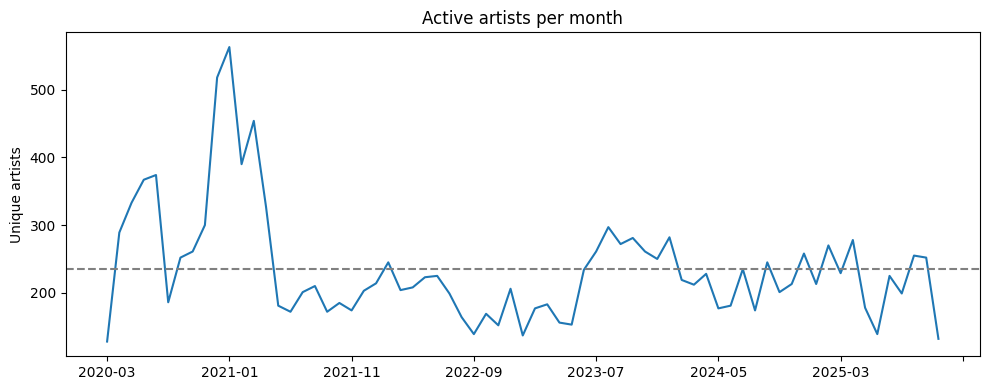

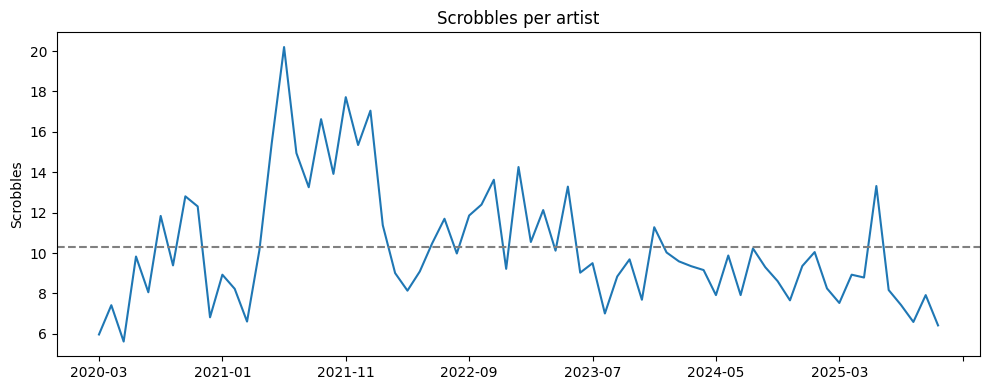

In [15]:
plt.figure(figsize=(10, 4))
artists_per_month.plot(kind="line")
plt.axhline(artists_per_month.mean(), linestyle="--", color="grey")
plt.title("Active artists per month")
plt.xlabel("")
plt.ylabel("Unique artists")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
scrobble_per_artist_per_month.plot(kind="line")
plt.axhline(scrobble_per_artist_per_month.mean(), linestyle="--", color="grey")
plt.title("Scrobbles per artist")
plt.xlabel("")
plt.ylabel("Scrobbles")
plt.tight_layout()
plt.show()


In [16]:
first_month_per_artist = df.groupby("artist_name")["month"].min()

new_artists_per_month = (
    first_month_per_artist.value_counts()
    .rename_axis("month")
    .reset_index(name="new_artists")
)

new_artists_per_month["year"] = new_artists_per_month["month"].str.slice(0, 4)
new_artists_per_month["month_num"] = new_artists_per_month["month"].str.slice(5, 7)

pivot_new = (
    new_artists_per_month
    .pivot(index="year", columns="month_num", values="new_artists")
    .fillna(0)
    .astype(int)
)

# Ensure columns ordered 01..12
pivot_new = pivot_new.reindex(columns=[f"{i:02d}" for i in range(1, 13)])

pivot_new


month_num,01,02,03,04,05,06,07,08,09,10,11,12
year,,,,,,,,,,,,
2020,0,0,128,216,211,156,107,71,102,80,83,295
2021,152,57,111,141,44,48,35,40,27,35,29,37
2022,27,45,27,31,20,22,21,23,12,20,13,18
2023,16,18,8,14,23,36,12,43,21,21,8,17
2024,31,8,2,13,5,9,14,7,9,9,8,20
2025,3,5,5,7,7,10,9,3,6,8,1,0


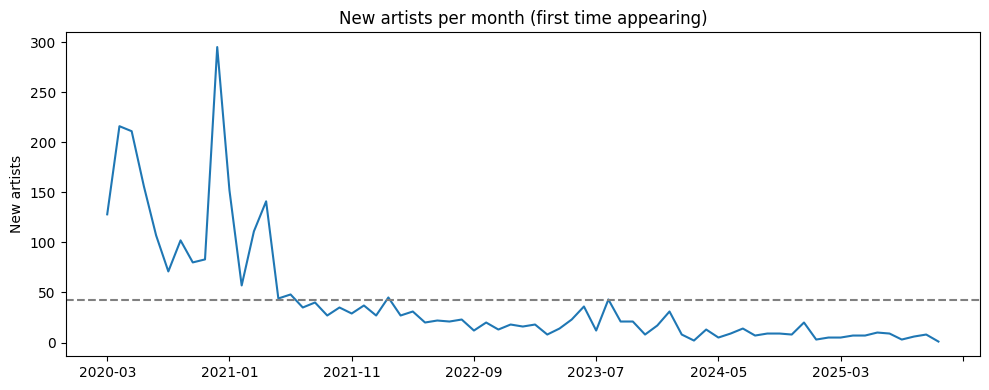

In [17]:
new_artists_per_month = first_month_per_artist.value_counts().sort_index()

plt.figure(figsize=(10, 4))
new_artists_per_month.plot(kind="line")
plt.axhline(new_artists_per_month.mean(), linestyle="--", color="grey")
plt.title("New artists per month (first time appearing)")
plt.xlabel("")
plt.ylabel("New artists")
plt.tight_layout()
plt.show()


In [18]:
artist_counts_all_time = df["artist_name"].value_counts()

print("Artists:", artist_counts_all_time.shape[0])
print("Scrobbles total:", int(artist_counts_all_time.sum()))
print("Median scrobbles/artist:", float(artist_counts_all_time.median()))
print("95th percentile:", float(artist_counts_all_time.quantile(0.95)))
print("99th percentile:", float(artist_counts_all_time.quantile(0.99)))

artist_counts_all_time.describe()


Artists: 2920
Scrobbles total: 160830
Median scrobbles/artist: 5.0
95th percentile: 246.09999999999945
99th percentile: 866.8699999999985


count    2920.000000
mean       55.078767
std       236.218796
min         1.000000
25%         1.000000
50%         5.000000
75%        22.000000
max      5444.000000
Name: count, dtype: float64

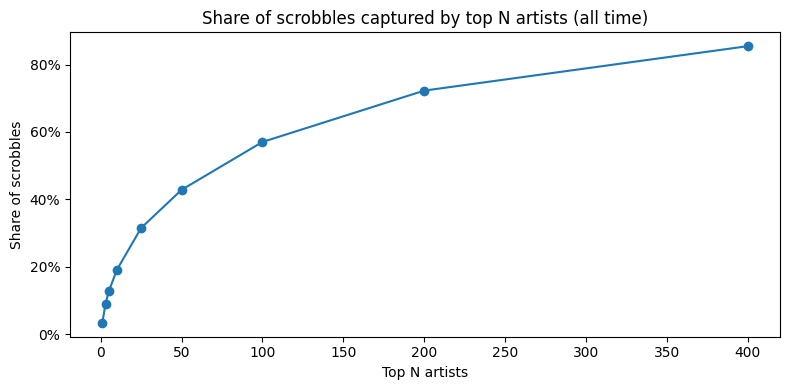

,share,share_pct
top_n,,
1,0.03,3.38
3,0.09,9.02
5,0.13,12.74
10,0.19,19.11
25,0.32,31.53
50,0.43,42.84
100,0.57,57.04
200,0.72,72.27
400,0.85,85.45


In [19]:
artist_counts_all_time = df["artist_name"].value_counts()
total_scrobbles = artist_counts_all_time.sum()

top_ns = [1, 3, 5, 10, 25, 50, 100, 200, 400]
shares = [artist_counts_all_time.head(n).sum() / total_scrobbles for n in top_ns]

share_topn = pd.Series(shares, index=top_ns)

plt.figure(figsize=(8, 4))
share_topn.plot(kind="line", marker="o")
plt.title("Share of scrobbles captured by top N artists (all time)")
plt.xlabel("Top N artists")
plt.ylabel("Share of scrobbles")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

share_topn.rename_axis("top_n").to_frame("share").assign(share_pct=lambda x: x["share"]*100).round(2)


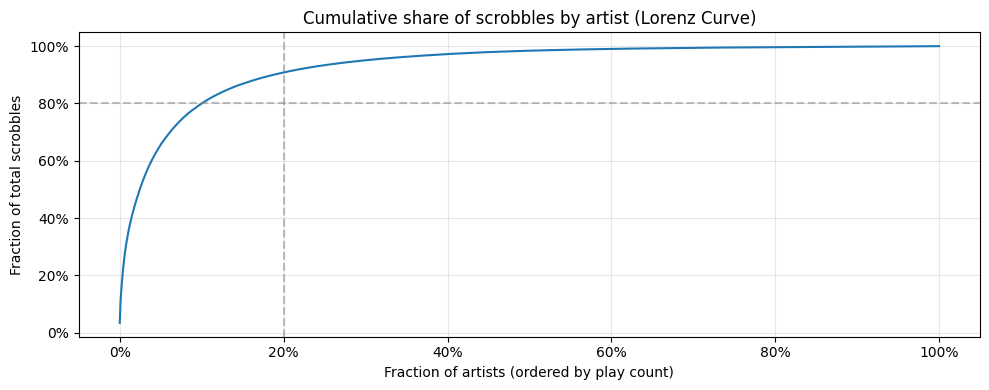

In [20]:
# calculate cumulative share to show concentration
artist_counts = df["artist_name"].value_counts()
cumulative_share = artist_counts.cumsum() / artist_counts.sum()
x_axis = np.arange(len(artist_counts)) / len(artist_counts)

plt.figure(figsize=(10, 4))
plt.plot(x_axis, cumulative_share.values)
plt.axhline(0.8, color="grey", linestyle="--", alpha=0.5)
plt.axvline(0.2, color="grey", linestyle="--", alpha=0.5)

plt.title("Cumulative share of scrobbles by artist (Lorenz Curve)")
plt.xlabel("Fraction of artists (ordered by play count)")
plt.ylabel("Fraction of total scrobbles")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

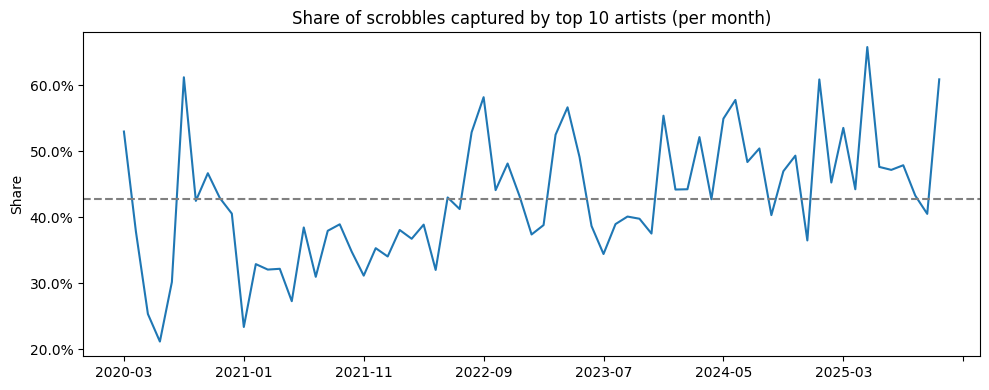

count    69.000000
mean      0.427977
std       0.095270
min       0.211810
25%       0.374104
50%       0.425011
75%       0.483888
max       0.658147
Name: artist_name, dtype: float64

In [21]:
def top_n_share_in_month(x, n=10):
    vc = x.value_counts()
    return vc.head(n).sum() / vc.sum()

top10_share_by_month = (
    df.groupby("month")["artist_name"]
    .apply(lambda s: top_n_share_in_month(s, n=10))
    .sort_index()
)

plt.figure(figsize=(10, 4))
top10_share_by_month.plot(kind="line")
plt.axhline(top10_share_by_month.mean(), linestyle="--", color="grey")
plt.title("Share of scrobbles captured by top 10 artists (per month)")
plt.xlabel("")
plt.ylabel("Share")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

top10_share_by_month.describe()


In [54]:
artist_month = (
    df.groupby(["month", "artist_name"])
    .size()
    .rename("plays_t")
    .reset_index()
)

artist_stats = (
    artist_month.groupby("artist_name")
    .agg(
        total_plays=("plays_t", "sum"),
        active_months=("month", "nunique"),
        peak_plays=("plays_t", "max"),
        median_plays=("plays_t", "median"),
    )
    .reset_index()
)

artist_stats["peak_to_median"] = artist_stats["peak_plays"] / artist_stats["median_plays"].replace(0, np.nan)

first_month = artist_month.groupby("artist_name")["month"].min().rename("first_month").reset_index()
last_month = artist_month.groupby("artist_name")["month"].max().rename("last_month").reset_index()

artist_stats = artist_stats.merge(first_month, on="artist_name", how="left")
artist_stats = artist_stats.merge(last_month, on="artist_name", how="left")

max_month = artist_month["month"].max()
recent_cutoff = str((pd.Period(max_month, freq="M") - 6).to_timestamp().to_period("M"))

# Select unique artists for plotting across categories
seen = set()

def get_top_unique(query_df, n=3):
    global seen
    candidates = query_df[~query_df["artist_name"].isin(seen)]
    selected = candidates.head(n)["artist_name"].tolist()
    seen.update(selected)
    return selected

top_total = get_top_unique(artist_stats.sort_values("total_plays", ascending=False))
spikiest = get_top_unique(artist_stats[artist_stats["active_months"] >= 6].sort_values("peak_to_median", ascending=False))
most_consistent = get_top_unique(artist_stats.sort_values(["active_months", "total_plays"], ascending=False))
new_artists = get_top_unique(artist_stats[(artist_stats["first_month"] >= recent_cutoff) & (artist_stats["active_months"] >= 3)].sort_values("total_plays", ascending=False))

archetypes = {
    "Top Overall": top_total,
    "Spikiest": spikiest,
    "Consistent": most_consistent,
    "New": new_artists
}

print('Suggested Artists to plot:')
for label, artists in archetypes.items():
    print(f"{label}: {artists}")

Suggested Artists to plot:
Top Overall: ['King Gizzard & The Lizard Wizard', 'Kanye West', 'Sufjan Stevens']
Spikiest: ['Madlib', 'Kid Cudi', 'Billy Woods']
Consistent: ['Kendrick Lamar', 'Salvador Sobral', 'Fleet Foxes']
New: ['Zaho de Sagazan', 'MJ Lenderman', 'Lola Young']


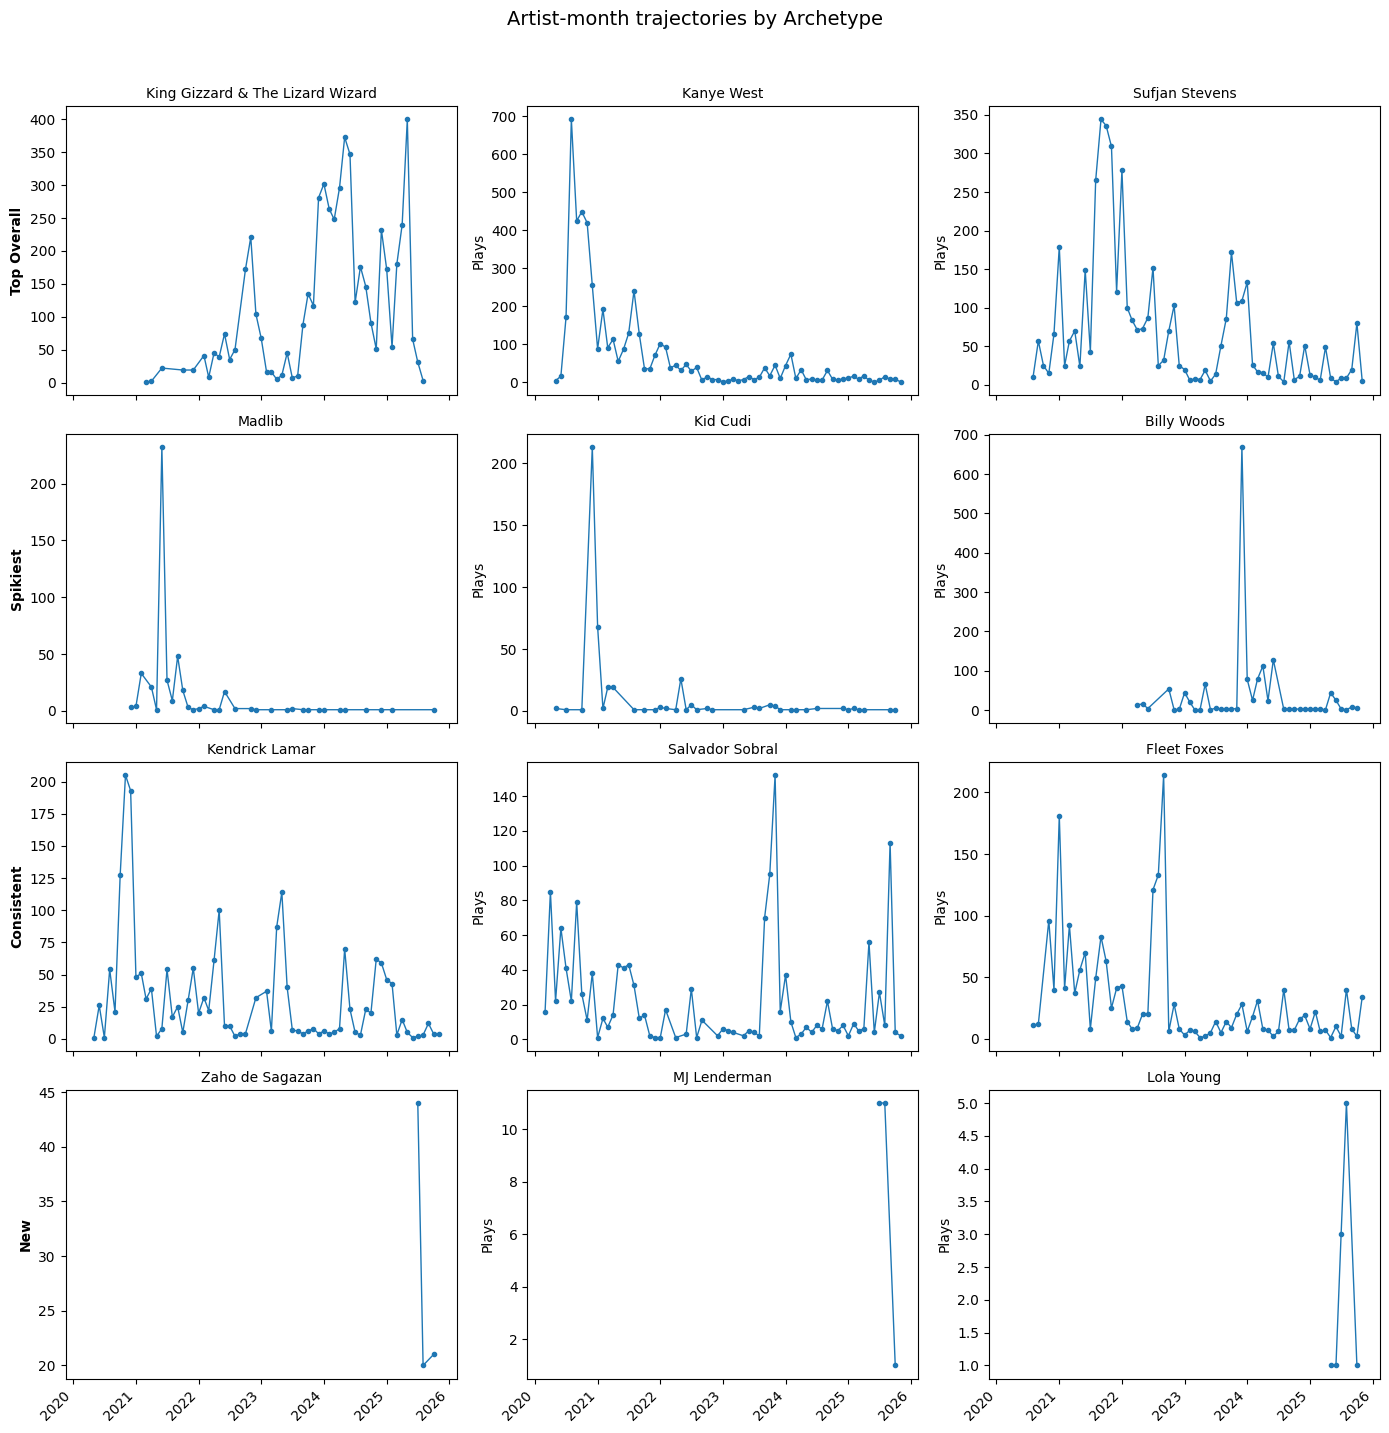

In [56]:
# Plot trajectories grouped by archetype with shared X-axis
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14, 14), sharex=True)

for row_idx, (label, artists) in enumerate(archetypes.items()):
    for col_idx, artist in enumerate(artists):
        ax = axes[row_idx, col_idx]
        s = artist_month[artist_month["artist_name"] == artist].copy()
        s["month_dt"] = pd.to_datetime(s["month"])
        s = s.sort_values("month_dt")
        
        ax.plot(s["month_dt"], s["plays_t"], marker="o", markersize=3, linewidth=1)
        ax.set_title(artist, fontsize=10)
        
        # Category label on the left of each row
        if col_idx == 0:
            ax.set_ylabel(f"{label}\n\nPlays", fontweight='bold')
        else:
            ax.set_ylabel("Plays")
        
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

fig.suptitle("Artist-month trajectories by Archetype", y=1.02, fontsize=14)
fig.tight_layout()
plt.show()

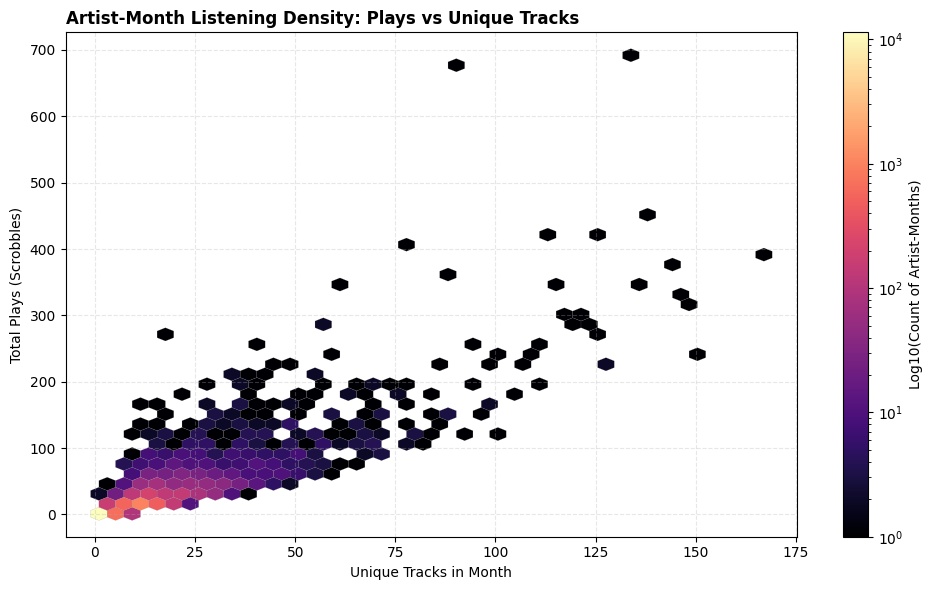

In [57]:
# Prettier density chart: plays vs unique tracks
plt.figure(figsize=(10, 6))

hb = plt.hexbin(
    artist_month_tracks["unique_tracks_t"], 
    artist_month_tracks["plays_t"], 
    gridsize=40, 
    bins="log", 
    cmap="magma",
    mincnt=1,
    edgecolors='gray',
    linewidths=0.1
)

cb = plt.colorbar(hb, label='Log10(Count of Artist-Months)')
plt.title("Artist-Month Listening Density: Plays vs Unique Tracks", loc='left', fontweight='bold')
plt.xlabel("Unique Tracks in Month")
plt.ylabel("Total Plays (Scrobbles)")
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Median plays/track: 1.0
95th percentile: 3.06
99th percentile: 5.67


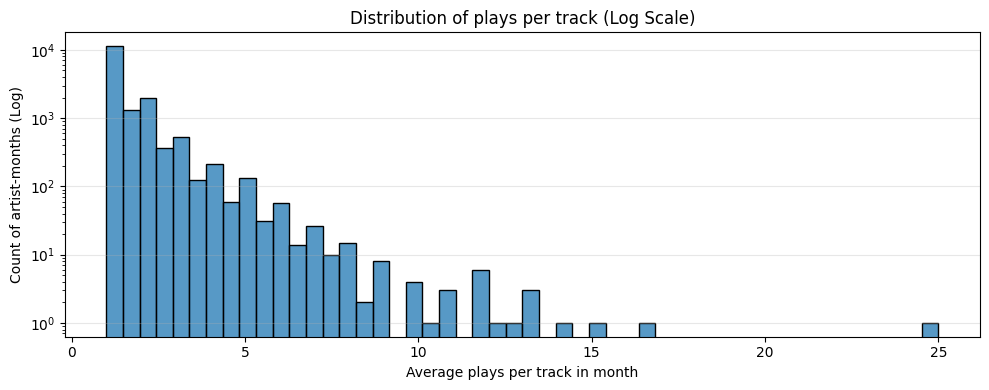

In [27]:
artist_month_tracks["plays_per_track_t"] = artist_month_tracks["plays_t"] / artist_month_tracks["unique_tracks_t"]
pp = artist_month_tracks["plays_per_track_t"]

print("Median plays/track:", round(float(pp.median()), 2))
print("95th percentile:", round(float(pp.quantile(0.95)), 2))
print("99th percentile:", round(float(pp.quantile(0.99)), 2))

plt.figure(figsize=(10, 4))
# log scale reveals the tail that is hidden in a linear histogram
sns.histplot(pp, bins=50, kde=False)
plt.yscale("log")
plt.title("Distribution of plays per track (Log Scale)")
plt.xlabel("Average plays per track in month")
plt.ylabel("Count of artist-months (Log)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [31]:
# Estimate cohort sizes for breakout modeling
first_month = artist_month.groupby("artist_name")["month"].transform("min")

# Calculate months since first appearance
curr_m = pd.to_datetime(artist_month["month"]).dt.to_period("M").astype(int)
first_m = pd.to_datetime(first_month).dt.to_period("M").astype(int)
artist_month["months_since_discovery"] = curr_m - first_m

# Eligible: new artist (<= 6 months) and minimum activity (>= 3 plays)
is_eligible = (artist_month["months_since_discovery"] <= 6) & (artist_month["plays_t"] >= 3)
artist_month["is_core"] = (artist_month["plays_t"] >= 20)

print(f"Total artist-month observations: {len(artist_month)}")
print(f"Eligible observations (New artists): {is_eligible.sum():,}")
print(f"Core/Heavy rotation events: {artist_month['is_core'].sum():,}")
print(f"Breakouts (Eligible AND Core): {(is_eligible & artist_month['is_core']).sum():,}")

Total artist-month observations: 16245
Eligible observations (New artists): 2,861
Core/Heavy rotation events: 2,144
Breakouts (Eligible AND Core): 844


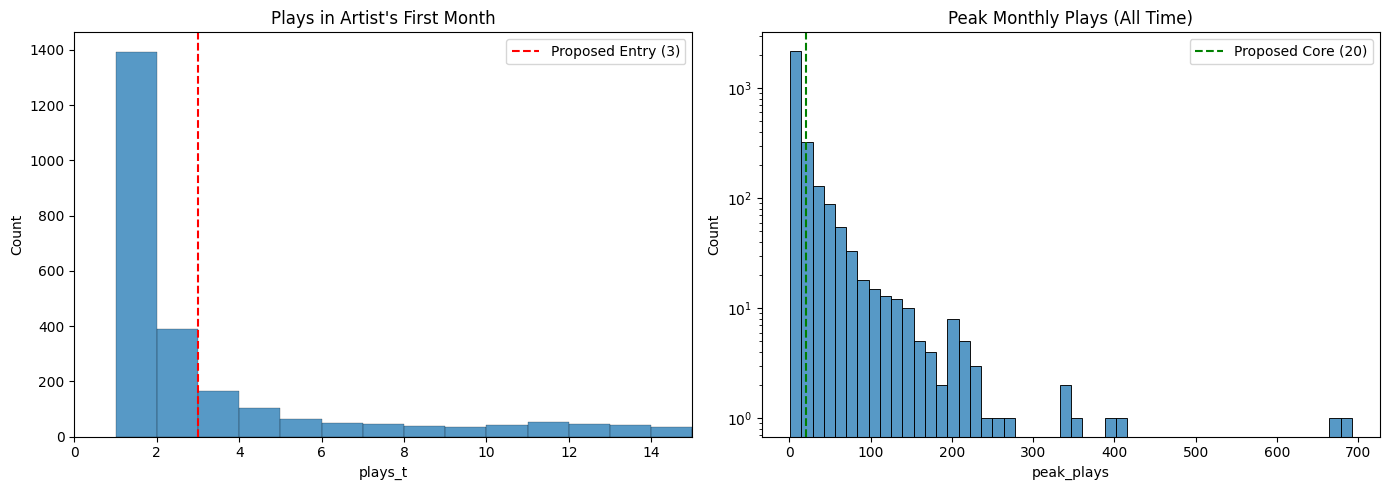

In [32]:
# validate the '3' (entry) and '20' (core) thresholds
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# check entry threshold (plays in the very first month)
first_month_plays = artist_month.sort_values("month").groupby("artist_name").head(1)["plays_t"]
sns.histplot(first_month_plays, binwidth=1, ax=ax[0])
ax[0].set_xlim(0, 15)
ax[0].axvline(3, color='r', linestyle='--', label='Proposed Entry (3)')
ax[0].set_title("Plays in Artist's First Month")
ax[0].legend()

# check core threshold (peak plays ever reached)
peak_plays = artist_stats["peak_plays"]
sns.histplot(peak_plays, bins=50, ax=ax[1])
ax[1].set_yscale("log")
ax[1].axvline(20, color='g', linestyle='--', label='Proposed Core (20)')
ax[1].set_title("Peak Monthly Plays (All Time)")
ax[1].legend()

plt.tight_layout()
plt.show()

In [41]:
# Check how many breakouts are driven by a single track (Playlist/SOTW indicator)
# We re-aggregate to ensure unique_tracks_t is available
artist_month_detail = (
    df.groupby(["month", "artist_name"])
    .agg(
        plays_t=("track_name", "count"),
        unique_tracks_t=("track_name", "nunique")
    )
    .reset_index()
)

# Merge back the eligibility and core flags we calculated earlier
artist_month_detail = artist_month_detail.merge(
    artist_month[['artist_name', 'month', 'months_since_discovery', 'is_core']], 
    on=['artist_name', 'month']
)

# Filter for the same 844 breakout events
breakouts = artist_month_detail[
    (artist_month_detail["months_since_discovery"] <= 6) & 
    (artist_month_detail["plays_t"] >= 3) & 
    (artist_month_detail["is_core"])
]

print(f"Avg unique tracks in a breakout month: {breakouts['unique_tracks_t'].mean():.2f}")
print(f"Breakouts with only 1-2 tracks: {(breakouts['unique_tracks_t'] <= 2).sum()}")
print(f"Breakouts with 8+ tracks (Album discovery): {(breakouts['unique_tracks_t'] >= 8).sum()}")

Avg unique tracks in a breakout month: 19.74
Breakouts with only 1-2 tracks: 1
Breakouts with 8+ tracks (Album discovery): 799


In [42]:
# Final Baseline Check: Forward-looking Breakouts
# We want to see if an eligible artist (New + Active) hits Core in the NEXT 2 months
artist_month = artist_month.sort_values(['artist_name', 'month'])

# 1. Create forward-looking targets
artist_month['next_m_plays'] = artist_month.groupby('artist_name')['plays_t'].shift(-1).fillna(0)
artist_month['next_2m_plays'] = artist_month.groupby('artist_name')['plays_t'].shift(-2).fillna(0)
artist_month['target_breakout'] = ((artist_month['next_m_plays'] >= 20) | (artist_month['next_2m_plays'] >= 20)).astype(int)

# 2. Define the training pool: New, Active, and NOT ALREADY CORE
# We only care about predicting the FIRST time they breakout
is_new = (artist_month["months_since_discovery"] <= 6)
is_active = (artist_month["plays_t"] >= 3)
is_not_yet_core = (artist_month["plays_t"] < 20) 

train_pool = artist_month[is_new & is_active & is_not_yet_core]

print(f"Total Eligible Predictions: {len(train_pool)}")
print(f"Actual Future Breakouts: {train_pool['target_breakout'].sum()}")
print(f"Baseline Precision (Predict All): {train_pool['target_breakout'].mean():.2%}")

Total Eligible Predictions: 2017
Actual Future Breakouts: 326
Baseline Precision (Predict All): 16.16%
